In [ ]:
import os
import torch
import torch.nn.functional as F
import math
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
print("Device:", DEVICE)

Device: cuda


In [ ]:
# MNIST preprocessing: normalize with dataset mean/std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [ ]:
train_full = datasets.MNIST(DRIVE_DIR, train=True, download=True, transform=transform)
test_set = datasets.MNIST(DRIVE_DIR, train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.42MB/s]


In [ ]:
# Split training set into train/validation (80/20)
val_split_ratio = 0.2
train_size = int((1 - val_split_ratio) * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = torch.utils.data.random_split(
    train_full, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

In [ ]:
def to_xy(dataset):
    """Convert dataset to tensors and move to device"""
    X = torch.stack([dataset[i][0] for i in range(len(dataset))]).to(DEVICE)
    y = torch.tensor([dataset[i][1] for i in range(len(dataset))], device=DEVICE, dtype=torch.long)
    return X, y

In [ ]:
# Convert datasets to tensors
X_train, y_train = to_xy(train_set)
X_val, y_val = to_xy(val_set)
X_test, y_test = to_xy(test_set)


In [ ]:
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: torch.Size([48000, 1, 28, 28]), torch.Size([48000])
Validation set: torch.Size([12000, 1, 28, 28]), torch.Size([12000])
Test set: torch.Size([10000, 1, 28, 28]), torch.Size([10000])


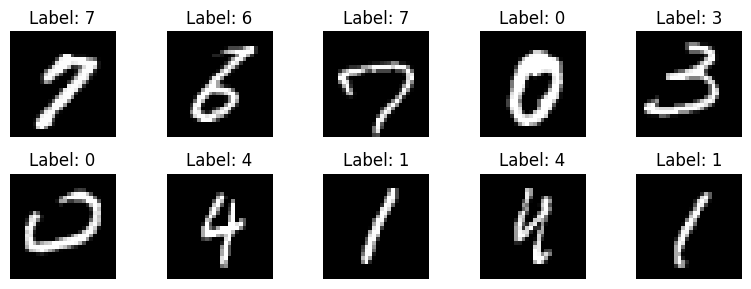

In [ ]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax in axes.ravel():
    i = torch.randint(0, len(train_set), (1,)).item()
    x, y = train_set[i]
    ax.imshow(x.squeeze().cpu(), cmap='gray')
    ax.set_title(f'Label: {y}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def zeros_like(x):
    """Create zero tensor with same shape, no gradients"""
    g = torch.zeros_like(x, device=x.device)
    g.requires_grad_(False)
    return g

In [ ]:
class Module:
    """
    Base class for all neural network layers.
    Handles forward pass and stores intermediate values for backward pass.
    """
    def __call__(self, *args):
        """Forward pass - store args and output for backward"""
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self, *args):
        """Forward pass - to be implemented by subclasses"""
        raise NotImplementedError

    def backward(self):
        """Backward pass - calls bwd with stored values"""
        self.bwd(self.out, *self.args)

    def bwd(self, *args):
        """Backward pass implementation - to be implemented by subclasses"""
        raise NotImplementedError

In [ ]:
class ReLU(Module):
    """
    ReLU activation function: f(x) = max(0, x)

    Forward: Apply ReLU element-wise
    Backward: Gradient is 1 where input > 0, else 0
    """

    def forward(self, x):
        """
        This function should apply the ReLU activation element-wise.

        Args:
            x: Input tensor of any shape.

        Returns:
            A tensor of the same shape as x, where every negative value
            in the input is replaced with 0.
        """
        return torch.clamp(x, min=0)

    def bwd(self, out, x):
        x.g = out.g * (x > 0).float()

In [ ]:
class Flatten(Module):
    """
    Flatten layer: reshapes input from [N, C, H, W] to [N, C*H*W]
    """
    def forward(self, x):
        # Save original shape for backward
        self.shape = x.shape
        # Flatten all dimensions except the batch size
        return x.view(x.size(0), -1)

    def bwd(self, out, x):
        # Restore the gradient back to original input shape
        x.g = out.g.view(self.shape)


In [ ]:


class Linear(Module):
    """
    Fully connected (linear) layer: y = x @ W + b
    """
    def __init__(self, in_features, out_features):
        # Provided initialization
        w = (torch.rand(in_features, out_features) * 2 - 1) * math.sqrt(6 / (in_features + out_features))
        self.w = w.to(DEVICE)
        self.w.requires_grad_(False)
        self.b = torch.zeros(out_features, device=DEVICE)

    def forward(self, x):
        # Linear transformation
        return x @ self.w + self.b

    def bwd(self, out, x):
        # Allocate gradient tensors (same shape as params)
        self.w.g = x.T @ out.g              # dL/dW
        self.b.g = out.g.sum(0)             # dL/db
        x.g = out.g @ self.w.T              # dL/dx


In [ ]:
class Conv2D(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        self.cin, self.cout = in_channels, out_channels
        if isinstance(kernel_size, int): kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int): stride = (stride, stride)
        if isinstance(padding, int): padding = (padding, padding)

        self.kH, self.kW = kernel_size
        self.stride = stride
        self.padding = padding

        fan_in = in_channels * self.kH * self.kW
        fan_out = out_channels * self.kH * self.kW
        limit = math.sqrt(6.0 / (fan_in + fan_out))
        self.W = ((torch.rand(out_channels, in_channels, self.kH, self.kW) * 2 - 1) * limit).to(DEVICE)
        self.W.requires_grad_(False)
        self.b = torch.zeros(out_channels, device=DEVICE) if bias else None

    def forward(self, x):
        N, C, H, W = x.shape
        assert C == self.cin
        self.in_shape = (N, C, H, W)

        # Unfold input → [N, C*kH*kW, L]
        X_unf = F.unfold(x, kernel_size=(self.kH, self.kW),
                         stride=self.stride, padding=self.padding)
        self.X_unf = X_unf

        # Reshape filters → [C_out, C_in*kH*kW]
        W_flat = self.W.view(self.cout, -1)

        # Perform batched matmul: [N, C_out, L]
        out = torch.bmm(W_flat.unsqueeze(0).expand(N, -1, -1), X_unf)

        # Add bias
        if self.b is not None:
            out += self.b.view(1, -1, 1)

        # Reshape to output shape
        H_out = (H + 2*self.padding[0] - self.kH)//self.stride[0] + 1
        W_out = (W + 2*self.padding[1] - self.kW)//self.stride[1] + 1
        self.out_spatial = (H_out, W_out)
        return out.view(N, self.cout, H_out, W_out)

    def bwd(self, out, x):
        N, C, H, W = self.in_shape
        H_out, W_out = self.out_spatial
        L = H_out * W_out

        G = out.g.view(N, self.cout, L)  # [N, C_out, L]
        W_flat = self.W.view(self.cout, -1)  # [C_out, C_in*kH*kW]

        # ---- Bias gradient ----
        if self.b is not None:
            self.b.g = G.sum(dim=(0, 2))

        # ---- Weight gradient ----
        Wg = torch.zeros_like(W_flat)
        for n in range(N):
            # [C_out, L] @ [L, C_in*kH*kW] → [C_out, C_in*kH*kW]
            Wg += G[n] @ self.X_unf[n].transpose(0, 1)
        self.W.g = Wg.view(self.cout, self.cin, self.kH, self.kW)

        # ---- Input gradient ----
        W_T = W_flat.T.unsqueeze(0).expand(N, -1, -1)  # [N, C_in*kH*kW, C_out]
        Xg_unf = torch.bmm(W_T, G)                    # [N, C_in*kH*kW, L]
        x.g = F.fold(
            Xg_unf,
            output_size=(H, W),
            kernel_size=(self.kH, self.kW),
            stride=self.stride,
            padding=self.padding
        )


In [ ]:
class MaxPool2D(Module):
    """
    2D Max Pooling layer

    Takes the maximum value in each pooling window
    """

    def __init__(self, kernel_size=2, stride=2):
        """Initialize pooling parameters (PROVIDED)"""
        self.k = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride

    def forward(self, x):
        N, C, H, W = x.shape
        self.in_shape = (N, C, H, W)

        # 1️ Unfold input into sliding local blocks (columns)
        X_unf = F.unfold(
            x,
            kernel_size=self.k,
            stride=self.stride
        )  # Shape: [N, C * kH * kW, L]
        self.X_unf = X_unf

        # 2 Number of windows per feature map
        kH, kW = self.k
        H_out = (H - kH) // self.stride[0] + 1
        W_out = (W - kW) // self.stride[1] + 1
        L = H_out * W_out

        # Reshape for pooling operation
        # Each patch: [N, C, kH*kW, L]
        X_cols = X_unf.view(N, C, kH * kW, L)

        # Compute max values and indices along patch dimension
        self.max_vals, self.max_idx = X_cols.max(dim=2)  # Shapes: [N, C, L]

        # Reshape max values into output feature map
        out = self.max_vals.view(N, C, H_out, W_out)
        return out

    def bwd(self, out, x):
        N, C, H, W = self.in_shape
        kH, kW = self.k
        H_out, W_out = (H - kH) // self.stride[0] + 1, (W - kW) // self.stride[1] + 1
        L = H_out * W_out

        # Initialize unfolded gradient tensor with zeros
        Xg_unf = torch.zeros_like(self.X_unf)  # Shape: [N, C*kH*kW, L]

        # Reshape to make indexing easier
        Xg_cols = Xg_unf.view(N, C, kH * kW, L)
        G_cols = out.g.view(N, C, L)  # [N, C, L]

        # Scatter gradients to max locations
        # Only the element that was max in each patch gets the gradient
        Xg_cols.scatter_(2, self.max_idx.unsqueeze(2), G_cols.unsqueeze(2))

        #  Fold (reverse of unfold) to reconstruct full gradient image
        x.g = F.fold(
            Xg_cols.view(N, C * kH * kW, L),
            output_size=(H, W),
            kernel_size=self.k,
            stride=self.stride
        )


In [ ]:
class CrossEntropy(Module):
    """
    Cross-entropy loss for classification

    Combines softmax and negative log-likelihood
    """

    def forward(self, logits, targets):
        N, C = logits.shape
        self.targets = targets

        logits_stable = logits - logits.max(dim=1, keepdim=True).values


        log_sum_exp = torch.log(torch.exp(logits_stable).sum(dim=1, keepdim=True))
        log_softmax = logits_stable - log_sum_exp  # shape: [N, C]


        loss_vals = -log_softmax[torch.arange(N), targets]


        self.out = loss_vals.mean()
        return self.out

    def bwd(self, out, logits, targets):
        N, C = logits.shape


        logits_stable = logits - logits.max(dim=1, keepdim=True).values
        exp_logits = torch.exp(logits_stable)
        softmax = exp_logits / exp_logits.sum(dim=1, keepdim=True)  # [N, C]


        one_hot = torch.zeros_like(softmax)
        one_hot[torch.arange(N), targets] = 1.0


        logits.g = (softmax - one_hot) / N


In [ ]:
class Sequential:
    """
    Container for chaining multiple layers together
    """

    def __init__(self, *layers):
        """Initialize with list of layers (PROVIDED)"""
        self.layers = list(layers)

    def __call__(self, x):
        """
        Forward pass through all layers in order.
        """
        for layer in self.layers:
            x = layer(x)     # Each layer returns its output
        return x              # Final output after all layers

    def backward(self, last_out):
        """
        Backward pass through all layers in reverse order.
        """
        # Propagate gradients backward through each layer
        for layer in reversed(self.layers):
            layer.backward()


In [ ]:
def params_of(net):
    """Extract all trainable parameters from network"""
    params = []
    for layer in net.layers:
        for name in ("W", "b", "w", "bias"):  # conv has W/b, linear has w/b
            if hasattr(layer, name):
                obj = getattr(layer, name)
                if obj is not None:
                    params.append(obj)
    return params

def sgd_step(params, lr):
    """Simple SGD parameter update"""
    with torch.no_grad():
        for p in params:
            p -= lr * p.g

def accuracy(logits, y):
    """Calculate classification accuracy"""
    return (logits.argmax(1) == y).float().mean().item()


In [ ]:
def build_cnn():
    """
    Build the CNN architecture according to the given specification.
    """
    net = Sequential(
        # 1. First conv block
        Conv2D(1, 8, kernel_size=3, stride=1, padding=1),  # 28x28 → 28x28
        ReLU(),
        MaxPool2D(kernel_size=2, stride=2),                # 28x28 → 14x14

        # 2. Second conv block
        Conv2D(8, 16, kernel_size=3, stride=1, padding=1), # 14x14 → 14x14
        ReLU(),
        MaxPool2D(kernel_size=2, stride=2),                # 14x14 → 7x7

        # 3. Flatten and Fully Connected
        Flatten(),                                         # 16×7×7 → 784
        Linear(16 * 7 * 7, 10)                             # 784 → 10 classes
    )
    return net


In [ ]:
def train_model(net, criterion, X_train, y_train, X_val, y_val, epochs=5, batch_size=128, lr=0.01):
    """
    Complete training and validation loop for the CNN from scratch.
    """
    # Get all trainable parameters
    params = params_of(net)
    print(f"Total parameters: {sum(p.numel() for p in params)}")

    # Lists to store training history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, epochs + 1):
        indices = torch.randperm(X_train.size(0))
        X_train = X_train[indices]
        y_train = y_train[indices]

        ep_loss, ep_correct, ep_total = 0.0, 0, 0

        for i in range(0, X_train.size(0), batch_size):
            # Get current mini-batch
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            logits = net(X_batch)
            loss = criterion(logits, y_batch)

            for p in params:
                p.g = torch.zeros_like(p)

            criterion.bwd(loss, logits, y_batch)  # compute logits.g
            net.backward(logits)                   # backprop through model

            sgd_step(params, lr)

            ep_loss += loss.item() * X_batch.size(0)
            ep_correct += (logits.argmax(1) == y_batch).sum().item()
            ep_total += X_batch.size(0)

        # Compute epoch-level training metrics
        train_loss = ep_loss / ep_total
        train_acc = ep_correct / ep_total

        with torch.no_grad():
            logits_val = net(X_val)
            val_loss = criterion(logits_val, y_val).item()
            val_acc = accuracy(logits_val, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% || "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
net = build_cnn()
criterion = CrossEntropy()

train_losses, val_losses, train_accs, val_accs = train_model(
    net, criterion, X_train, y_train, X_val, y_val,
    epochs=5, batch_size=128, lr=0.01
)


Total parameters: 9098
Epoch [1/5] Train Loss: 0.8049 | Train Acc: 76.68% || Val Loss: 0.3298 | Val Acc: 90.53%
Epoch [2/5] Train Loss: 0.2665 | Train Acc: 92.06% || Val Loss: 0.2498 | Val Acc: 92.56%
Epoch [3/5] Train Loss: 0.2002 | Train Acc: 94.08% || Val Loss: 0.1987 | Val Acc: 94.14%
Epoch [4/5] Train Loss: 0.1647 | Train Acc: 95.13% || Val Loss: 0.1622 | Val Acc: 95.21%
Epoch [5/5] Train Loss: 0.1417 | Train Acc: 95.81% || Val Loss: 0.1415 | Val Acc: 95.86%


Building CNN...
Starting training...
Total parameters: 9098
Epoch [1/5] Train Loss: 1.0775 | Train Acc: 67.43% || Val Loss: 0.4009 | Val Acc: 88.23%
Epoch [2/5] Train Loss: 0.2969 | Train Acc: 91.28% || Val Loss: 0.2611 | Val Acc: 92.12%
Epoch [3/5] Train Loss: 0.2188 | Train Acc: 93.66% || Val Loss: 0.1968 | Val Acc: 94.31%
Epoch [4/5] Train Loss: 0.1768 | Train Acc: 94.75% || Val Loss: 0.1687 | Val Acc: 95.38%
Epoch [5/5] Train Loss: 0.1522 | Train Acc: 95.44% || Val Loss: 0.1486 | Val Acc: 95.81%


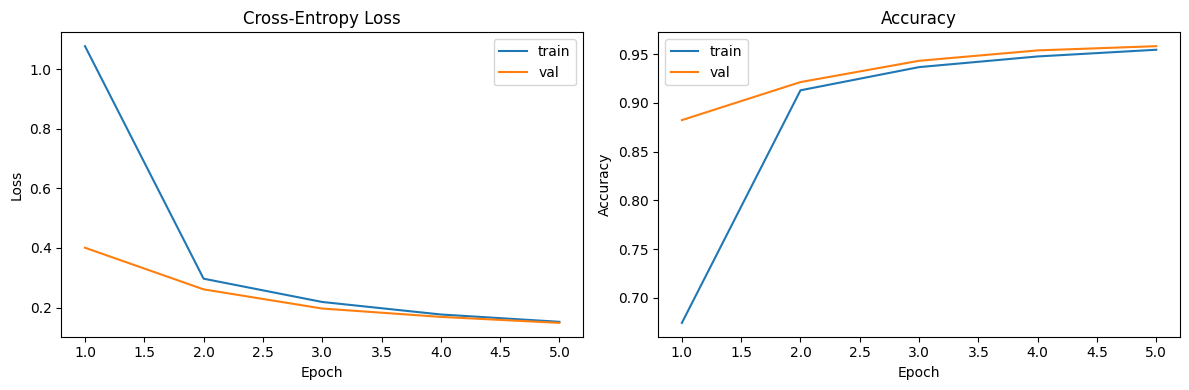


Final Test Results: loss 0.1276 | acc 0.9635
Please implement the TODO sections to complete the assignment!


In [ ]:



print("Building CNN...")
net = build_cnn()
criterion = CrossEntropy()

print("Starting training...")
train_losses, val_losses, train_accs, val_accs = train_model(
    net, criterion, X_train, y_train, X_val, y_val,
    epochs=5, batch_size=128, lr=0.01
)

# Plot training curves
epochs_axis = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_axis, train_losses, label='train')
plt.plot(epochs_axis, val_losses, label='val')
plt.title('Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_axis, train_accs, label='train')
plt.plot(epochs_axis, val_accs, label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final test evaluation
with torch.no_grad():
    test_logits = net(X_test)
    test_loss = criterion(test_logits, y_test).item()
    test_acc = accuracy(test_logits, y_test)
print(f"\nFinal Test Results: loss {test_loss:.4f} | acc {test_acc:.4f}")

